# Scalable Bayesian Modeling

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/symeneses/SBM/blob/main/notebooks/example.ipynb)

This example is based on the NumPyro Tutorial: [Bayesian Hierarchical Linear Regression](https://num.pyro.ai/en/stable/tutorials/bayesian_hierarchical_linear_regression.html).

In [ ]:
# Execute only if executing in Google Colab
# !rm -r ./src
# !rm -r ./data
# !git clone https://github.com/symeneses/SBM
# !mv ./SBM/src ./src
# !mv ./SBM/data ./data
# !rm -r ./SBM
# !pip install --upgrade pip
# !pip install --upgrade numpyro==0.11.0 pymc==5.0.2 blackjax==0.9.6 seaborn

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

cores = os.cpu_count()
os.environ["XLA_FLAGS"] = f'--xla_force_host_platform_device_count={cores}'
root_path = os.path.abspath(os.pardir)
if root_path not in sys.path:
    sys.path.append(root_path)

## Importing the needed libraries

In [2]:
import pandas as pd
import numpy as np
import numpyro
import pymc as pm

from src.data import data_generator
from src.handler import Handler
from src.diagnostics import convergency_validator, dist_validator
from src.plots import plot_ess_ps, plot_monitor

pd.set_option('display.precision', 2)
RANDOM_SEED = 8957


/opt/homebrew/Caskroom/miniconda/base/envs/sbm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/Caskroom/miniconda/base/envs/sbm/lib/python3.11/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


## Getting the data

Create a Pandas [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) with the variables to be used to define the model.

✍🏽 User input required.

In [3]:
# Code to generate the data, name the final results as data
data = pd.read_csv(
    "https://gist.githubusercontent.com/ucals/"
    "2cf9d101992cb1b78c2cdd6e3bac6a4b/raw/"
    "43034c39052dcf97d4b894d2ec1bc3f90f3623d9/"
    "osic_pulmonary_fibrosis.csv"
)
data["patient_codes"], _ = data["Patient"].factorize()

## Defining the model

In the following cells, write the code for the models you want to compare. To make comparing the models and results easier, use the same name of variables in each version of the model.

**For models in PyMC:** Create an annotated function, as in the example, that returns a `pm.model.Model`.

**For models in Numpyro:** Use the same variable names of the `DataFrame` `data` for the arguments of the function model. These arguments should contain only columns present in `data`.

✍🏽 User input required.

In [4]:
def pymc_model_gen(data: pd.DataFrame) -> pm.model.Model:
    patient_codes = data['patient_codes'].values
    codes = np.unique(patient_codes)
    coords = {"patients": codes}
    weeks = data['Weeks']
    FVC_obs = data['FVC']
    with pm.Model(coords=coords) as pymc_model:

        mu_alpha = pm.Normal("μ_α", mu=0.0, sigma=500.0)
        sigma_alpha = pm.HalfNormal("σ_α", sigma=100.0)
        mu_beta = pm.Normal("μ_β", mu=0.0, sigma=3.0)
        sigma_beta = pm.HalfNormal("σ_β", sigma=3.0)

        alpha = pm.Normal("α", mu=mu_alpha, sigma=sigma_alpha, dims="patients")
        beta = pm.Normal("β", mu=mu_beta, sigma=sigma_beta, dims="patients")

        sigma = pm.HalfNormal("σ", sigma=100.0)

        FVC_est = alpha[data['patient_codes']] + beta[data['patient_codes']] * weeks

        y = pm.Normal("y", mu=FVC_est, sigma=sigma, observed=FVC_obs)
    return pymc_model


In [5]:
import numpyro.distributions as dist
from numpyro.infer import NUTS


def model(patient_codes, Weeks, FVC=None):
    patient_codes = patient_codes.values
    Weeks = Weeks.values
    FVC = FVC.values
    μ_α = numpyro.sample("μ_α", dist.Normal(0.0, 500.0))
    σ_α = numpyro.sample("σ_α", dist.HalfNormal(100.0))
    μ_β = numpyro.sample("μ_β", dist.Normal(0.0, 3.0))
    σ_β = numpyro.sample("σ_β", dist.HalfNormal(3.0))

    n_patients = len(np.unique(patient_codes))

    with numpyro.plate("plate_i", n_patients):
        α = numpyro.sample("α", dist.Normal(μ_α, σ_α))
        β = numpyro.sample("β", dist.Normal(μ_β, σ_β))

    σ = numpyro.sample("σ", dist.HalfNormal(100.0))
    FVC_est = α[patient_codes] + β[patient_codes] * Weeks

    with numpyro.plate("data", len(patient_codes)):
        numpyro.sample("obs", dist.Normal(FVC_est, σ), obs=FVC)

numpyro_kernel = NUTS(model)

## Inference
Here, we will create create valid [InferenceData](https://python.arviz.org/en/latest/api/generated/arviz.InferenceData.html) objects and a set of metrics to measure performance for the selected models, data sizes and samplers.

In [6]:
data.shape

(1549, 8)

### Creating multiple data sizes

To have a benchmark using different data sizes, we will use the function `data_generator` which will use the original dataset to generate datasets with the given `sizes` or filtering the original data in the parameter `filters`. You can also add Gaussian noise to selected variables using the parameter `include_noise`.

✍🏽 User input required.

In [7]:
data_sizes = [1549, 5000, 10000]
datasets = data_generator(data, include_noise=["FVC"], sizes=data_sizes)
# If you want to work only with the original data, use this instead
# datasets = {"1549": data}

### Sampling

⚠️ You should at least use 2 chains to be able to calculate correctly the diagnostics.

✍🏽 User input required.

In [8]:
# Use the following path if working in Google Colab
# output_path = "data/results"
output_path = "../data/results"
models = {"pymc": pymc_model_gen, "numpyro": numpyro_kernel}
pymc_samplers = ["default", "numpyro", "blackjax"]
draws = 2000
tune = 2000
# It's recommended to use between 2 and 4 chains
chains = 2

# sampling all models
handler = Handler(models, datasets, pymc_samplers, output_path)
infer_data, results = handler.execute(draws, tune, chains, RANDOM_SEED)


> Getting samples using libray pymc:

>> Getting samples for data with size 1549

>>> Getting samples using the PYMC sampler default


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ_α, σ_α, μ_β, σ_β, α, β, σ]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.



>>> Getting samples using the PYMC sampler numpyro
Compiling...
Compilation time =  0:00:04.312205
Sampling...
Sampling time =  0:00:33.231842
Transforming variables...
Transformation time =  0:00:00.063299

>>> Getting samples using the PYMC sampler blackjax
Compiling...
Compilation time =  0:00:04.696216
Sampling...
Sampling time =  0:00:11.736372
Transforming variables...
Transformation time =  0:00:29.328924

>> Getting samples for data with size 5000

>>> Getting samples using the PYMC sampler default


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ_α, σ_α, μ_β, σ_β, α, β, σ]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 139 seconds.



>>> Getting samples using the PYMC sampler numpyro
Compiling...
Compilation time =  0:00:04.516224
Sampling...
Sampling time =  0:00:25.606890
Transforming variables...
Transformation time =  0:00:00.033146

>>> Getting samples using the PYMC sampler blackjax
Compiling...
Compilation time =  0:00:04.256870
Sampling...
Sampling time =  0:00:11.500604
Transforming variables...
Transformation time =  0:01:44.291214

>> Getting samples for data with size 10000

>>> Getting samples using the PYMC sampler default


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ_α, σ_α, μ_β, σ_β, α, β, σ]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 179 seconds.



>>> Getting samples using the PYMC sampler numpyro
Compiling...
Compilation time =  0:00:04.262374
Sampling...
Sampling time =  0:00:46.185972
Transforming variables...
Transformation time =  0:00:00.033099

>>> Getting samples using the PYMC sampler blackjax
Compiling...
Compilation time =  0:00:04.255622
Sampling...
Sampling time =  0:00:11.569960
Transforming variables...
Transformation time =  0:00:00.627068

> Getting samples using libray numpyro:

>> Getting samples for data with size 1549


Running chain 1: 100%|██████████| 4000/4000 [00:18<00:00, 212.34it/s]



>> Getting samples for data with size 5000


Running chain 1: 100%|██████████| 4000/4000 [00:28<00:00, 139.49it/s]



>> Getting samples for data with size 10000


Running chain 1: 100%|██████████| 4000/4000 [00:46<00:00, 85.63it/s] 


## Check Convergency

After sampling, the function `convergency_validator` will help you know if the models have converged. This function use the [rank normalized splitR-hat](https://python.arviz.org/en/latest/api/generated/arviz.rhat.html).

An $\hat R$ > 1.05 indicates convergence failures. In this case, the results of the next step `Validate Results` **can't be considered** as they assumed the MCMC has converged. 

In [9]:
convergency_validator(infer_data)

Convergency test using R-hat:
> pymc_default_1549       : 1.00 ✅
> pymc_numpyro_1549       : 1.00 ✅
> pymc_blackjax_1549      : 1.01 ✅
> pymc_default_5000       : 1.01 ✅
> pymc_numpyro_5000       : 1.00 ✅
> pymc_blackjax_5000      : 3.68 ❌
> pymc_default_10000      : 1.00 ✅
> pymc_numpyro_10000      : 1.01 ✅
> pymc_blackjax_10000     : 7011090589029262.00 ❌
> numpyro_default_1549    : 1.01 ✅
> numpyro_default_5000    : 1.01 ✅
> numpyro_default_10000   : 1.01 ✅


## Validate results 

To check that the models are sampling from the same distributions. The function `dist_validator` will estimate the ranges of the mean for each variable using the [MCSE](https://python.arviz.org/en/latest/api/generated/arviz.mcse.html) of one of the models as reference. You can either give a `seed` to choose a model randomly or give the key `ref_key` of a selected model. The reference model will be compared only with others using the same sample size.

The percentages displayed indicate how many variables are within the calculated range using ±3 sigma. The values should be in theory greater or equal to `95%` following a weaker [three-sigma rule](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule).

In [10]:
results_val, summaries = dist_validator(infer_data, ref_key="pymc_numpyro_1549")

Percentage of variables with the expected mean using MCSE:
> pymc_default_1549       :  95.52% using as a reference pymc_numpyro_1549        ✅
> pymc_numpyro_1549       : 100.00% using as a reference pymc_numpyro_1549        ✅
> pymc_blackjax_1549      :  11.76% using as a reference pymc_numpyro_1549        ❌
> pymc_default_5000       :  98.04% using as a reference pymc_numpyro_5000        ✅
> pymc_numpyro_5000       : 100.00% using as a reference pymc_numpyro_5000        ✅
> pymc_blackjax_5000      :   0.00% using as a reference pymc_numpyro_5000        ❌
> pymc_default_10000      :  98.88% using as a reference pymc_numpyro_10000       ✅
> pymc_numpyro_10000      : 100.00% using as a reference pymc_numpyro_10000       ✅
> pymc_blackjax_10000     :   0.28% using as a reference pymc_numpyro_10000       ❌
> numpyro_default_1549    :  97.20% using as a reference pymc_numpyro_1549        ✅
> numpyro_default_5000    :  97.76% using as a reference pymc_numpyro_5000        ✅
> numpyro_default

## Comparison

### Resources metrics

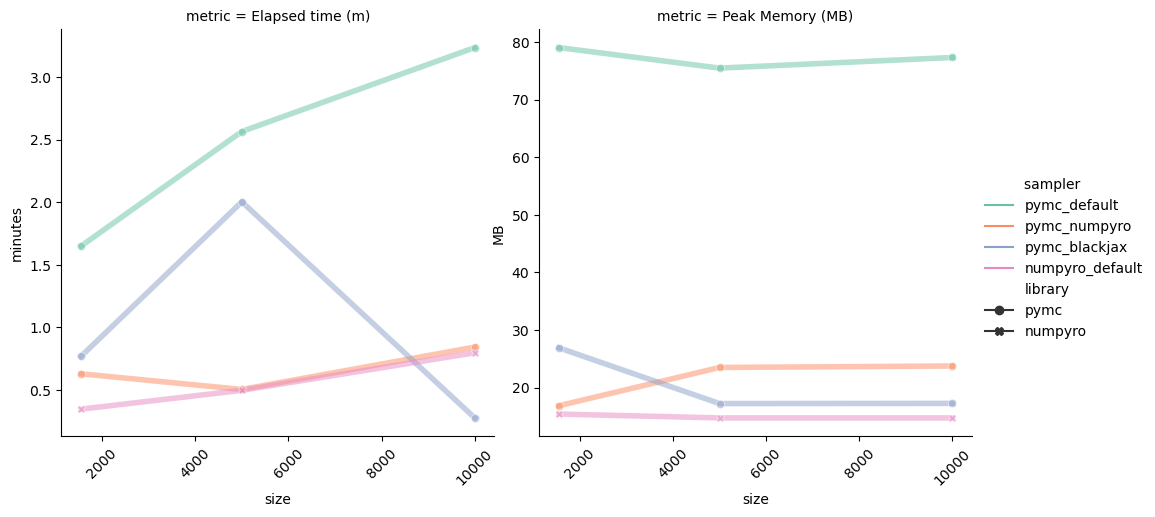

In [11]:
plot_monitor(results)

### ESS

To determine the sampler performance, we use the **Effective Sample Size** ([ESS](https://python.arviz.org/en/latest/api/generated/arviz.ess.html])) calculated per second.

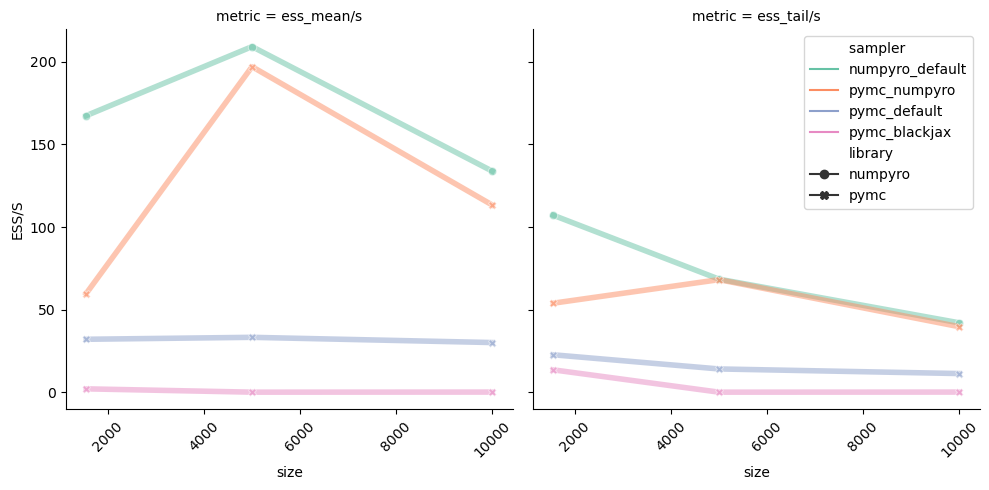

In [12]:
plot_ess_ps(results, summaries, data_sizes=data_sizes)

Using 'ESS per Second' previously calculated


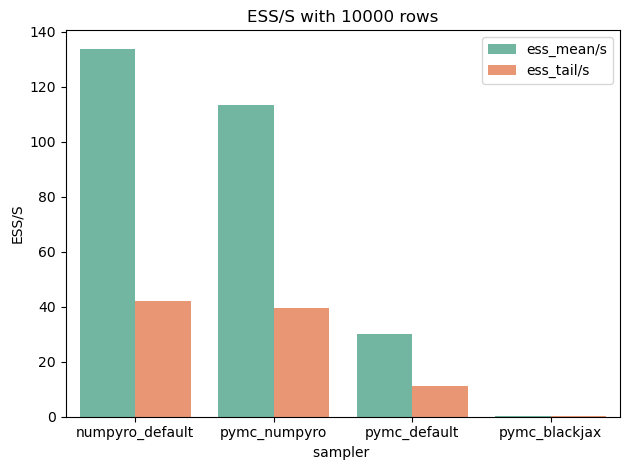

In [14]:
plot_ess_ps(results, summaries, data_sizes=[max(data_sizes)])

Let's rank the best across all data sizes:

In [15]:
summary = results.drop(columns=["current_memory", "peak_memory"])
summary["rank"] = summary.sort_values(["size", "ess_mean/s"], ascending=[True, False]) \
            .groupby(['size']) \
            .cumcount() + 1
summary.sort_values(["size", "rank"])

,library,sampler,size,elapsed_time,Peak Memory (MB),Elapsed time (m),ess_mean/s,ess_tail/s,rank
numpyro_default_1549,numpyro,default,1549.0,20.80,15.42,0.35,167.41,1.07e+02,1
pymc_numpyro_1549,pymc,numpyro,1549.0,37.74,16.87,0.63,59.73,5.39e+01,2
pymc_default_1549,pymc,default,1549.0,98.97,79.01,1.65,32.03,2.26e+01,3
pymc_blackjax_1549,pymc,blackjax,1549.0,46.13,26.93,0.77,2.02,1.35e+01,4
numpyro_default_5000,numpyro,default,5000.0,29.82,14.75,0.50,209.21,6.84e+01,1
pymc_numpyro_5000,pymc,numpyro,5000.0,30.22,23.51,0.50,197.06,6.81e+01,2
pymc_default_5000,pymc,default,5000.0,153.88,75.45,2.56,33.21,1.41e+01,3
pymc_blackjax_5000,pymc,blackjax,5000.0,120.18,17.24,2.00,0.01,8.32e-03,4
numpyro_default_10000,numpyro,default,10000.0,47.81,14.75,0.80,133.79,4.20e+01,1
pymc_numpyro_10000,pymc,numpyro,10000.0,50.54,23.76,0.84,113.28,3.96e+01,2


Let's see the best options in each data size:

In [16]:
summary.query("rank == 1").sort_values("size")

,library,sampler,size,elapsed_time,Peak Memory (MB),Elapsed time (m),ess_mean/s,ess_tail/s,rank
numpyro_default_1549,numpyro,default,1549.0,20.80,15.42,0.35,167.41,107.14,1
numpyro_default_5000,numpyro,default,5000.0,29.82,14.75,0.50,209.21,68.42,1
numpyro_default_10000,numpyro,default,10000.0,47.81,14.75,0.80,133.79,41.98,1
